<a href="https://colab.research.google.com/github/Serag11/Machine-Learning/blob/main/Sign_Language_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
import torchvision.models as models # Import torchvision models



In [3]:
!pip install opendatasets
import pandas as pd
import opendatasets as od
od.download('https://www.kaggle.com/datasets/datamunge/sign-language-mnist')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kkk
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist


100%|██████████| 62.6M/62.6M [00:00<00:00, 1.78GB/s]

In [4]:
df_train = pd.read_csv('/content/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
df_test  = pd.read_csv('/content/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')


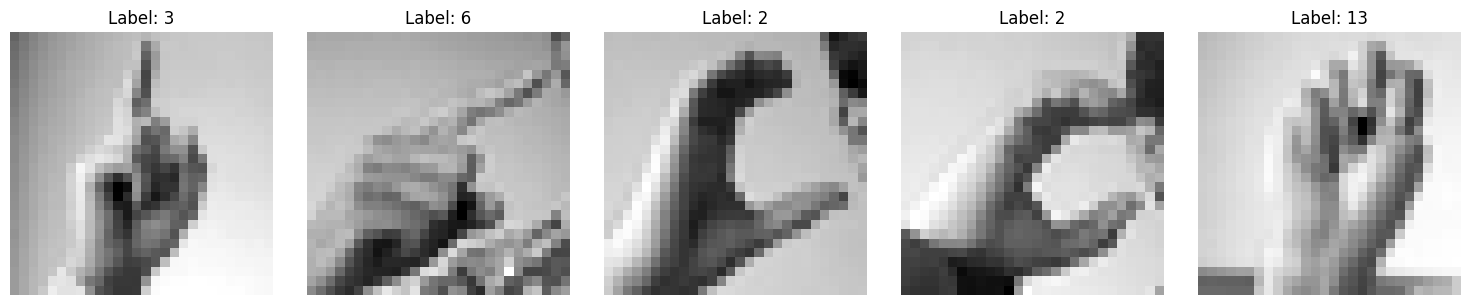

In [5]:
# Extract pixel data from the training dataframe
pixel_data = df_train.drop('label', axis=1).values

# Reshape the pixel data into 28x28 images
images = pixel_data.reshape(-1, 28, 28)

# Display a few reconstructed images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Label: {df_train.iloc[i]['label']}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [6]:
def evaluate(data_loader: DataLoader):
  model.eval()
  all_labels = []
  all_predictions = []
  correct = 0
  total = 0
  total_loss = 0.0

  with torch.no_grad():
      for images, labels in data_loader:
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          loss = criterion(outputs, labels)
          total_loss += loss.item()
          _, predicted = torch.max(outputs, 1)

          all_labels.extend(labels.cpu().numpy())
          all_predictions.extend(predicted.cpu().numpy())

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  f1 = f1_score(all_labels, all_predictions, average='weighted')
  accuracy = 100 * correct / total
  avg_loss = total_loss / len(data_loader)


  return avg_loss, accuracy, f1

In [7]:


# Define a custom Dataset class for Sign Language MNIST
class SignLanguageMNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.labels = dataframe['label'].values
        # Drop the 'label' column to get pixel data
        self.pixel_data = dataframe.drop('label', axis=1).values
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.pixel_data[idx].reshape(28, 28).astype(np.uint8) # Reshape to 28x28 and ensure uint8 for ToTensor
        label = self.labels[idx]

        # Apply transforms if any
        if self.transform:
            image = self.transform(image)

        return image, label

# Transforms
# We convert to PIL Image first because ToTensor expects PIL Image or NumPy ndarray (H x W x C)
# Our image is H x W, so we pass it as is, and ToTensor will handle it as 1-channel.
transform = transforms.Compose([
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    transforms.ToTensor()    # Convert PIL Image to PyTorch Tensor (adds channel dimension)
])

# Create custom datasets
train_data = SignLanguageMNISTDataset(df_train, transform=transform)
test_data = SignLanguageMNISTDataset(df_test, transform=transform)

# Dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=64, shuffle=False)

# 1. Using custom CNN

In [8]:
class CustomCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),    # 14x14x32
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  #7x7x64
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #3x3x128
    )


    self.classifier = nn.Sequential(
        nn.Linear(128 * 3 * 3, 512),
        nn.ReLU(),
        nn.Linear(512, 25)
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1) # Flatten all dimensions except batch
    x = self.classifier(x)
    return x



In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)
torchinfo.summary(model, input_size=(1, 1 ,28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
CustomCNN                                [1, 25]                   --
├─Sequential: 1-1                        [1, 128, 3, 3]            --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           18,496
│    └─ReLU: 2-5                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 64, 7, 7]             --
│    └─Conv2d: 2-7                       [1, 128, 7, 7]            73,856
│    └─ReLU: 2-8                         [1, 128, 7, 7]            --
│    └─MaxPool2d: 2-9                    [1, 128, 3, 3]            --
├─Sequential: 1-2                        [1, 25]                   --
│    └─Linear: 2-10                      [1, 512]                  590,336
│

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [11]:

for epoch in range(3):   # change num epochs
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{10}"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss/len(train_loader)
    val_loss, val_acc, val_f1 = evaluate(test_loader)
    print(f"Epoch [{epoch+1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")



Epoch 1/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.9949, Validation Loss: 0.3519, Validation Accuracy: 87.62%


Epoch 2/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.0394, Validation Loss: 0.3010, Validation Accuracy: 91.51%


Epoch 3/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.0057, Validation Loss: 0.3040, Validation Accuracy: 91.66%


In [ ]:
_ , accuracy , f1 = evaluate(test_loader)
print(f"Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}")

Accuracy: 92.85%, F1 Score: 0.9275


# 2. Using data augmentation

In [ ]:
augmetation_transform = transforms.Compose([
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    transforms.RandomRotation(10), # Rotate by a maximum of 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10), # Translate and shear
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Apply color jitter
    transforms.ToTensor(),    # Convert PIL Image to PyTorch Tensor (adds channel dimension)
])
# Create custom datasets
train_data_augmentation = SignLanguageMNISTDataset(df_train, transform=augmetation_transform)
test_data_augmentation = SignLanguageMNISTDataset(df_test, transform=augmetation_transform)

# Dataloaders
train_loader_augmentation = DataLoader(train_data_augmentation, batch_size=64, shuffle=True)
test_loader_augmentation  = DataLoader(test_data_augmentation,  batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)
torchinfo.summary(model, input_size=(1, 1 ,28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
CustomCNN                                [1, 25]                   --
├─Sequential: 1-1                        [1, 128, 3, 3]            --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           18,496
│    └─ReLU: 2-5                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 64, 7, 7]             --
│    └─Conv2d: 2-7                       [1, 128, 7, 7]            73,856
│    └─ReLU: 2-8                         [1, 128, 7, 7]            --
│    └─MaxPool2d: 2-9                    [1, 128, 3, 3]            --
├─Sequential: 1-2                        [1, 25]                   --
│    └─Linear: 2-10                      [1, 512]                  590,336
│

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:

for epoch in range(10):   # change num epochs
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader_augmentation, desc=f"Epoch {epoch+1}/{10}"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss/len(train_loader_augmentation)
    val_loss, val_acc, val_f1 = evaluate(test_loader_augmentation)
    print(f"Epoch [{epoch+1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")


Epoch 1/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1.6373, Validation Loss: 0.7754, Validation Accuracy: 73.27%


Epoch 2/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.4100, Validation Loss: 0.3651, Validation Accuracy: 87.23%


Epoch 3/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.1990, Validation Loss: 0.3180, Validation Accuracy: 88.41%


Epoch 4/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.1230, Validation Loss: 0.1970, Validation Accuracy: 93.64%


Epoch 5/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 0.0746, Validation Loss: 0.1603, Validation Accuracy: 94.81%


Epoch 6/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.0657, Validation Loss: 0.1467, Validation Accuracy: 95.32%


Epoch 7/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.0498, Validation Loss: 0.1504, Validation Accuracy: 95.43%


Epoch 8/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.0523, Validation Loss: 0.1265, Validation Accuracy: 96.04%


Epoch 9/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.0408, Validation Loss: 0.1072, Validation Accuracy: 96.57%


Epoch 10/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.0386, Validation Loss: 0.1624, Validation Accuracy: 95.19%


In [ ]:
_ , accuracy , f1 = evaluate(test_loader_augmentation)
print(f"Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}")

Accuracy: 95.50%, F1 Score: 0.9548


# 3. Using transfer learning

In [ ]:

alexnet_transform = transforms.Compose([
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    transforms.Resize((224, 224)), # Resize images to 224x224 for AlexNet
    transforms.ToTensor(),    # Convert PIL Image to PyTorch Tensor (adds channel dimension)
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])
# Create custom datasets
train_data_resnet = SignLanguageMNISTDataset(df_train, transform=alexnet_transform)
test_data_resnet = SignLanguageMNISTDataset(df_test, transform=alexnet_transform)

# Dataloaders
train_loader_resnet = DataLoader(train_data_resnet, batch_size=64, shuffle=True)
test_loader_resnet  = DataLoader(test_data_resnet,  batch_size=64, shuffle=False)

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 25)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 44.2MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

In [ ]:
for epoch in range(3):   # change num epochs
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader_resnet, desc=f"Epoch {epoch+1}/{10}"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss/len(train_loader_resnet)
    val_loss, val_acc, val_f1 = evaluate(test_loader_resnet)
    print(f"Epoch [{epoch+1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")



Epoch 1/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1.1188, Validation Loss: 0.6407, Validation Accuracy: 85.12%


Epoch 2/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.3526, Validation Loss: 0.4142, Validation Accuracy: 89.85%


Epoch 3/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.2186, Validation Loss: 0.3449, Validation Accuracy: 90.32%


# 4. Using architecture (ResNet-50)

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=None)

model.fc = nn.Linear(2048, 25)

model = model.to(device)
# torchinfo.summary(model, input_size=(1, 3 ,224, 224)) # Update input_size to reflect 1 channel and 224x224


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:


for epoch in range(3):   # change num epochs
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader_resnet, desc=f"Epoch {epoch+1}/{10}"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss/len(train_loader_resnet)
    val_loss, val_acc, val_f1 = evaluate(test_loader_resnet)
    print(f"Epoch [{epoch+1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")



Epoch 1/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.7472, Validation Loss: 0.1439, Validation Accuracy: 94.79%


Epoch 2/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.0456, Validation Loss: 0.5730, Validation Accuracy: 86.25%


Epoch 3/10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.0053, Validation Loss: 0.0109, Validation Accuracy: 99.68%
